In [1]:
%load_ext tensorboard

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pathlib

from tensorflow import keras
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

2022-09-22 16:03:48.417229: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-22 16:03:48.417261: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
!rm -rf ./logs/

In [4]:
WIDTH, HEIGHT = 20, 20
IMAGE_SIZE = (WIDTH, HEIGHT)

batch_size = 32
epochs = 100

## Augment image

Apply random rotation, brightness and zoom to the image.
Resize the image to 20x20 pixels
Rescale pixel values to [0, 1] instead of [0, 255]

In [6]:
augment_image = keras.Sequential([
    keras.layers.RandomRotation((-0.07, 0.07), "nearest"),
    keras.layers.RandomBrightness(0.1),
    keras.layers.RandomZoom(0.1, fill_mode="nearest")
])

rescale_resize = keras.Sequential([
    layers.Rescaling(1./255),
    layers.Resizing(WIDTH, HEIGHT)
])

In [11]:
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "training_data",
    validation_split = 0.2,
    subset = "training",
    seed = 7892,
    color_mode = "grayscale",
    image_size = IMAGE_SIZE,
    batch_size = batch_size
)

augmented_ds = training_ds.map(lambda x,y: (augment_image(x), y))
final_training_ds = augmented_ds.map(lambda x,y: (rescale_resize(x), y))


validation_original = tf.keras.preprocessing.image_dataset_from_directory(
    "training_data",
    validation_split = 0.2,
    subset = "validation",
    seed = 7892,
    color_mode = "grayscale",
    image_size = IMAGE_SIZE,
    batch_size = batch_size
)

validation_ds = validation_original.map(lambda x,y: (rescale_resize(x), y))

Found 20630 files belonging to 9 classes.
Using 16504 files for training.


Found 20630 files belonging to 9 classes.
Using 4126 files for validation.


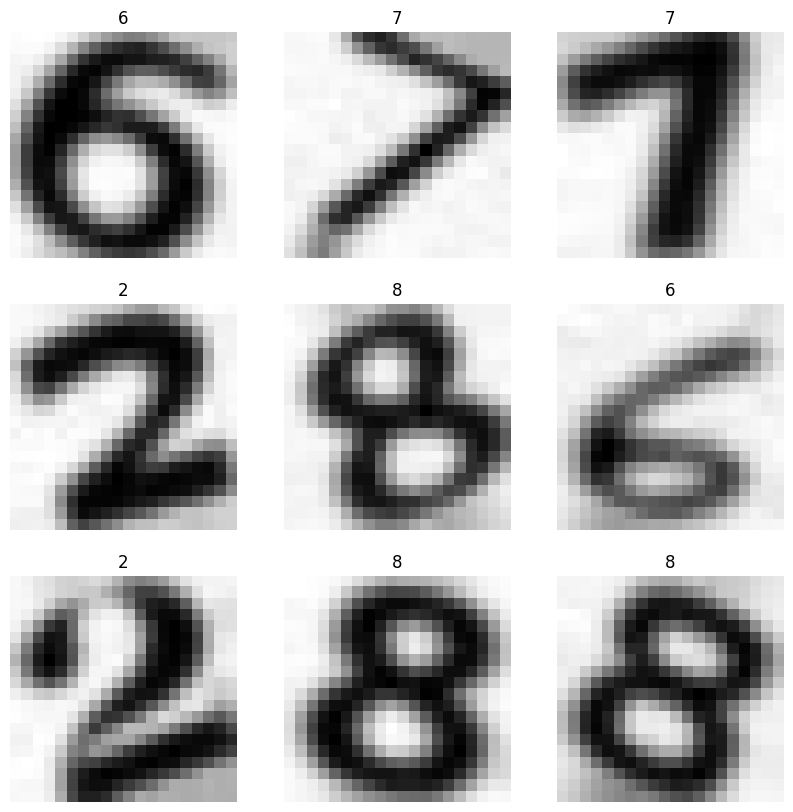

In [13]:
class_names = training_ds.class_names
plt.figure(figsize=(10,10))
for images, labels in final_training_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("float32"), cmap="gray")
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [14]:
num_classes = len(class_names)
model = Sequential([
    Conv2D(16, 3, 
                  padding="same", 
                  activation="relu",
                  input_shape=(HEIGHT, WIDTH, 1)
                 ),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(
        50,
        activation="relu"
    ),
    Dense(
        num_classes, 
        activation="softmax",
        name="output")
])


In [15]:
model.compile(optimizer="adam",
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"]
             )

history = model.fit(final_training_ds,
                    validation_data=validation_ds, 
                    epochs=epochs)

Epoch 1/100
516/516 [==============================] - 5s 10ms/step - loss: 0.6757 - accuracy: 0.8040 - val_loss: 0.1508 - val_accuracy: 0.9634
Epoch 2/100
516/516 [==============================] - 4s 8ms/step - loss: 0.2348 - accuracy: 0.9343 - val_loss: 0.1032 - val_accuracy: 0.9721
Epoch 3/100
516/516 [==============================] - 4s 8ms/step - loss: 0.1762 - accuracy: 0.9499 - val_loss: 0.0843 - val_accuracy: 0.9770
Epoch 4/100
516/516 [==============================] - 4s 9ms/step - loss: 0.1466 - accuracy: 0.9573 - val_loss: 0.0755 - val_accuracy: 0.9779
Epoch 5/100
516/516 [==============================] - 5s 10ms/step - loss: 0.1247 - accuracy: 0.9632 - val_loss: 0.0767 - val_accuracy: 0.9760
Epoch 6/100
516/516 [==============================] - 5s 9ms/step - loss: 0.1102 - accuracy: 0.9702 - val_loss: 0.0577 - val_accuracy: 0.9816
Epoch 7/100
516/516 [==============================] - 5s 9ms/step - loss: 0.0971 - accuracy: 0.9720 - val_loss: 0.0433 - val_accuracy: 0.98

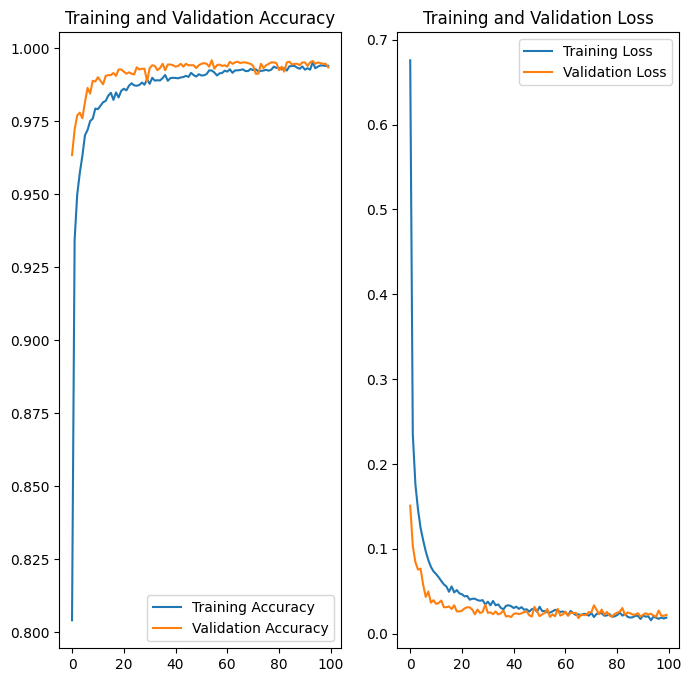

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
model.save("trained.model")

INFO:tensorflow:Assets written to: trained.model/assets


INFO:tensorflow:Assets written to: trained.model/assets


In [18]:
all_data_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "all_data",
    seed = 7892,
    color_mode = "grayscale",
    image_size = IMAGE_SIZE,
    batch_size = batch_size
)

augmented_all_data_ds = all_data_ds.map(lambda x,y: (augment_image(x), y))
final_all_data_ds = augmented_all_data_ds.map(lambda x,y: (rescale_resize(x), y))

Found 22923 files belonging to 9 classes.


In [19]:
model.fit(final_all_data_ds,
         epochs = 50)

Epoch 1/50
717/717 [==============================] - 5s 7ms/step - loss: 0.0142 - accuracy: 0.9958
Epoch 2/50
717/717 [==============================] - 6s 8ms/step - loss: 0.0123 - accuracy: 0.9964
Epoch 3/50
717/717 [==============================] - 5s 7ms/step - loss: 0.0108 - accuracy: 0.9969
Epoch 4/50
717/717 [==============================] - 5s 7ms/step - loss: 0.0102 - accuracy: 0.9967
Epoch 5/50
717/717 [==============================] - 5s 7ms/step - loss: 0.0087 - accuracy: 0.9971
Epoch 6/50
717/717 [==============================] - 5s 7ms/step - loss: 0.0081 - accuracy: 0.9975
Epoch 7/50
717/717 [==============================] - 5s 7ms/step - loss: 0.0090 - accuracy: 0.9973
Epoch 8/50
717/717 [==============================] - 5s 7ms/step - loss: 0.0083 - accuracy: 0.9971
Epoch 9/50
717/717 [==============================] - 5s 7ms/step - loss: 0.0055 - accuracy: 0.9981
Epoch 10/50
717/717 [==============================] - 5s 7ms/step - loss: 0.0059 - accuracy: 0.9982

In [20]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, "tfjs_model")